In [80]:
import keras
from keras.applications import MobileNetV2
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Activation, Flatten, Conv2D, Conv1D,MaxPooling2D,Dropout,BatchNormalization
from keras import models
from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.utils import to_categorical
import random
import pandas as pd
import numpy as np
import matplotlib
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import skimage.transform
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [81]:
%%time
#Load Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Take sample
trainindex = random.sample(range(0,len(x_train)),10000)
testindex = random.sample(range(0,len(x_test)),2000)

x_train = x_train[trainindex]
y_train = y_train[trainindex]
x_test = x_test[testindex]
y_test = y_test[testindex]

y_train = to_categorical(y_train,num_classes=10)
y_test = to_categorical(y_test,num_classes=10)

CPU times: user 129 ms, sys: 199 ms, total: 328 ms
Wall time: 335 ms


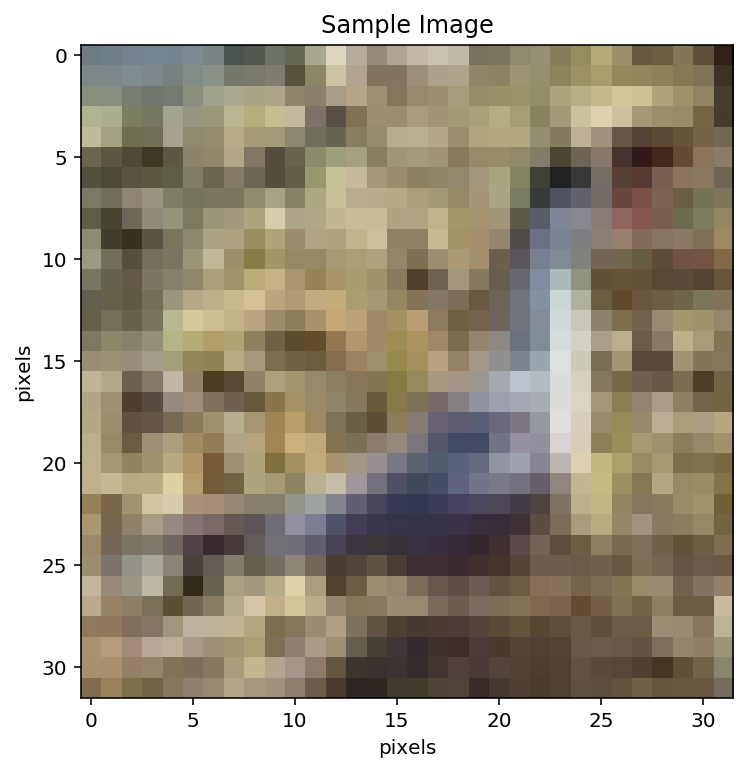

In [82]:
plt.figure(figsize=(6,6))
plt.title('Sample Image')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.imshow(x_train[7]);

In [83]:
%%time
new_train = []
new_test = []

for i,image in enumerate(x_train): 
    new_image = skimage.transform.resize(image, (96, 96,3), mode='constant')
    new_train.append(new_image)
for i,image in enumerate(x_test):
    new_image = skimage.transform.resize(image, (96, 96,3), mode='constant')
    new_test.append(new_image)

x_train = np.asarray(new_train)
x_test = np.asarray(new_test)

/Users/LiamRoberts/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


CPU times: user 17.4 s, sys: 1.93 s, total: 19.3 s
Wall time: 19.4 s


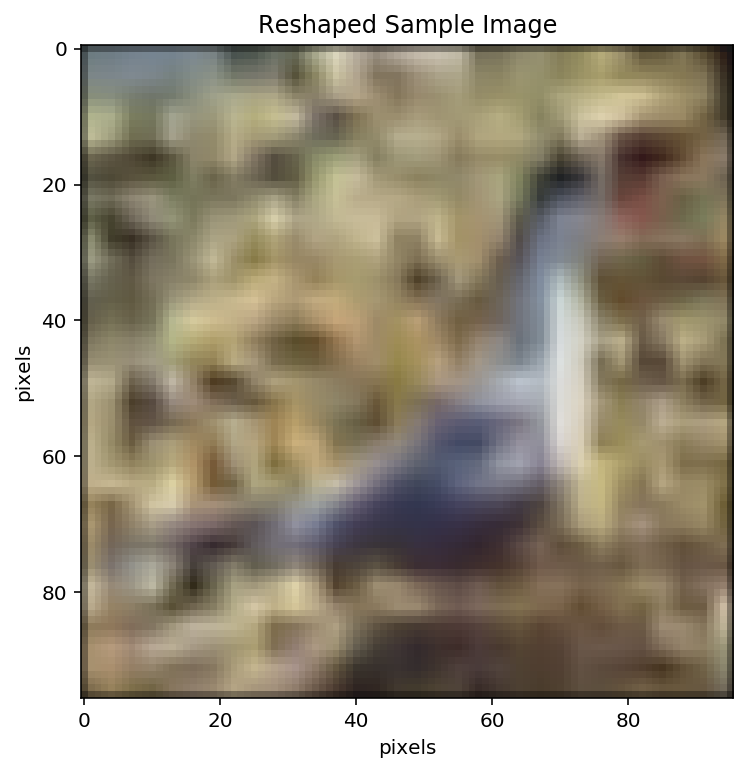

In [84]:
plt.figure(figsize=(6,6))
plt.title('Reshaped Sample Image')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.imshow(x_train[7]);

In [85]:
conv_base = MobileNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(96,96,3))

In [86]:
%%time
#Get Features using Pre Trained MobileNetV2 Model (~9min/1000 images)
train_feats = conv_base.predict(x_train)
test_feats = conv_base.predict(x_test)
feat_shape = train_feats.shape
print(f'New Features Shape: {feat_shape}')

New Features Shape: (10000, 3, 3, 1280)
CPU times: user 27min 21s, sys: 3min 50s, total: 31min 11s
Wall time: 5min 18s


In [87]:
train_feats = train_feats.reshape((feat_shape[0],
                                   feat_shape[1]*feat_shape[2]*feat_shape[3]))

test_feats = test_feats.reshape((len(test_feats),
                                 feat_shape[1]*feat_shape[2]*feat_shape[3]))

In [91]:
model = models.Sequential()
model.add(Dense(512, input_dim = 3*3*1280,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               5898752   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
Total params: 6,166,538
Trainable params: 6,166,538
Non-trainable params: 0
_________________________________________________________________


In [92]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=5, 
                           mode='min', 
                           verbose=1)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_feats, y_train, epochs=100, validation_data=(test_feats,y_test),batch_size=128,callbacks=[early_stop])

Train on 10000 samples, validate on 2000 samples
Epoch 1/100
10000/10000 [==============================] - 15s 2ms/step - loss: 1.7651 - acc: 0.4744 - val_loss: 0.9771 - val_acc: 0.6760
Epoch 2/100
10000/10000 [==============================] - 11s 1ms/step - loss: 1.1805 - acc: 0.6069 - val_loss: 0.8869 - val_acc: 0.7075
Epoch 3/100
10000/10000 [==============================] - 11s 1ms/step - loss: 1.0470 - acc: 0.6540 - val_loss: 0.8008 - val_acc: 0.7385
Epoch 4/100
10000/10000 [==============================] - 12s 1ms/step - loss: 0.9022 - acc: 0.7053 - val_loss: 0.7950 - val_acc: 0.7380
Epoch 5/100
10000/10000 [==============================] - 12s 1ms/step - loss: 0.8607 - acc: 0.7144 - val_loss: 0.7729 - val_acc: 0.7485
Epoch 6/100
10000/10000 [==============================] - 12s 1ms/step - loss: 0.8034 - acc: 0.7300 - val_loss: 0.8344 - val_acc: 0.7345
Epoch 7/100
10000/10000 [==============================] - 12s 1ms/step - loss: 0.7830 - acc: 0.7389 - val_loss: 0.7426 - v